In [ ]:
import xml.etree.ElementTree as ET
import numpy as np
import re
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
# from google.colab import drive
# drive.mount('/content/drive')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# xml_path = "drive/MyDrive/assignment/O-A0038-003.xml"
xml_path = "O-A0038-003.xml"
tree = ET.parse(xml_path)
root = tree.getroot()

ns = {'ns': 'urn:cwa:gov:tw:cwacommon:0.1'}
content_elem = root.find('.//ns:Content', ns)
content_text = content_elem.text.strip()

tokens = re.split(r'[,\s]+', content_text)
vals = [float(t) for t in tokens if t != '']

n_cols, n_rows = 67, 120
arr = np.array(vals).reshape((n_rows, n_cols))

lon0, lat0, res = 120.00, 21.88, 0.03

records = []
for i in range(n_rows):
    for j in range(n_cols):
        lon = lon0 + j * res
        lat = lat0 + i * res
        v = arr[i, j]
        label = 0 if v <= -900 else 1
        records.append((lon, lat, v, label))

data = np.array(records, dtype=float)

classification_data = data[:, [0, 1, 3]]
regression_data = data[data[:, 3] == 1][:, [0, 1, 2]]

scaler = StandardScaler()
scaler.fit(data[:, :2])

classification_data[:, :2] = scaler.transform(classification_data[:, :2])
regression_data[:, :2] = scaler.transform(regression_data[:, :2])

In [ ]:
class ClassificationDataset(Dataset):
    def __init__(self, arr):
        self.x = torch.tensor(arr[:, :2], dtype=torch.float32)
        self.y = torch.tensor(arr[:, 2], dtype=torch.long)
    def __len__(self):
        return len(self.x)
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

class RegressionDataset(Dataset):
    def __init__(self, arr):
        self.x = torch.tensor(arr[:, :2], dtype=torch.float32)
        self.y = torch.tensor(arr[:, 2], dtype=torch.float32).unsqueeze(1)
    def __len__(self):
        return len(self.x)
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

clf_dataset = ClassificationDataset(classification_data)
reg_dataset = RegressionDataset(regression_data)

def split_dataset(dataset, ratio=0.8):
    n_train = int(len(dataset) * ratio)
    n_val = len(dataset) - n_train
    return random_split(dataset, [n_train, n_val])

clf_train, clf_val = split_dataset(clf_dataset)
reg_train, reg_val = split_dataset(reg_dataset)

clf_loader = DataLoader(clf_train, batch_size=1024, shuffle=True)
clf_val_loader = DataLoader(clf_val, batch_size=1024)
reg_loader = DataLoader(reg_train, batch_size=1024, shuffle=True)
reg_val_loader = DataLoader(reg_val, batch_size=1024)

In [ ]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 10),
            nn.ReLU(),
            nn.Linear(10, 16),
            nn.ReLU(),
            nn.Linear(16, 10),
            nn.ReLU(),
            nn.Linear(10, 2)
        )
    def forward(self, x):
        return self.net(x)

class Regressor(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 10),
            nn.ReLU(),
            nn.Linear(10, 16),
            nn.ReLU(),
            nn.Linear(16, 10),
            nn.ReLU(),
            nn.Linear(10, 1)
        )
    def forward(self, x):
        return self.net(x)

In [ ]:
clf_model, reg_model = Classifier().to(device), Regressor().to(device)

clf_criterion = nn.CrossEntropyLoss()
reg_criterion = nn.MSELoss()
clf_optimizer = optim.Adam(clf_model.parameters(), lr=1e-3)
reg_optimizer = optim.Adam(reg_model.parameters(), lr=1e-3)

def train_classifier(model, loader, optimizer, criterion):
    model.train()
    total_loss, correct, total = 0, 0, 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * len(y)
        preds = out.argmax(dim=1)
        correct += (preds == y).sum().item()
        total += len(y)
    return total_loss/total, correct/total

def eval_classifier(model, loader, criterion):
    model.eval()
    total_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            loss = criterion(out, y)
            total_loss += loss.item() * len(y)
            preds = out.argmax(dim=1)
            correct += (preds == y).sum().item()
            total += len(y)
    return total_loss/total, correct/total

def train_regressor(model, loader, optimizer, criterion):
    model.train()
    total_loss, total = 0, 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * len(y)
        total += len(y)
    return total_loss/total

def eval_regressor(model, loader, criterion):
    model.eval()
    total_loss, total = 0, 0
    preds_all, y_all = [], []
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            loss = criterion(out, y)
            total_loss += loss.item() * len(y)
            total += len(y)
            preds_all.append(out.cpu())
            y_all.append(y.cpu())
    return total_loss/total, torch.cat(preds_all), torch.cat(y_all)

In [ ]:
EPOCHS = 1000
clf_train_accs, clf_val_accs = [], []
reg_train_losses, reg_val_losses = [], []

for epoch in range(1, EPOCHS+1):
    clf_train_loss, clf_train_acc = train_classifier(clf_model, clf_loader, clf_optimizer, clf_criterion)
    clf_val_loss, clf_val_acc = eval_classifier(clf_model, clf_val_loader, clf_criterion)
    reg_train_loss = train_regressor(reg_model, reg_loader, reg_optimizer, reg_criterion)
    reg_val_loss, preds, y_true = eval_regressor(reg_model, reg_val_loader, reg_criterion)

    clf_train_accs.append(clf_train_acc)
    clf_val_accs.append(clf_val_acc)
    reg_train_losses.append(reg_train_loss)
    reg_val_losses.append(reg_val_loss)

    if epoch % 100 == 0:
      print(f"Epoch {epoch:02d}: "
          f"Clf[acc={clf_train_acc:.3f}, val_acc={clf_val_acc:.3f}] | "
          f"Reg[loss={reg_train_loss:.4f}, val_loss={reg_val_loss:.4f}]")

Epoch 100: Clf[acc=0.968, val_acc=0.968] | Reg[loss=29.1622, val_loss=30.4873]
Epoch 200: Clf[acc=0.972, val_acc=0.971] | Reg[loss=25.2033, val_loss=25.7405]
Epoch 300: Clf[acc=0.976, val_acc=0.976] | Reg[loss=22.7571, val_loss=23.0713]
Epoch 400: Clf[acc=0.981, val_acc=0.980] | Reg[loss=19.3022, val_loss=19.1371]
Epoch 500: Clf[acc=0.982, val_acc=0.983] | Reg[loss=15.2798, val_loss=14.5475]
Epoch 600: Clf[acc=0.983, val_acc=0.983] | Reg[loss=13.0005, val_loss=11.9399]
Epoch 700: Clf[acc=0.983, val_acc=0.984] | Reg[loss=12.1487, val_loss=11.0433]
Epoch 800: Clf[acc=0.982, val_acc=0.985] | Reg[loss=11.7188, val_loss=10.6378]
Epoch 900: Clf[acc=0.983, val_acc=0.984] | Reg[loss=11.3048, val_loss=10.3277]
Epoch 1000: Clf[acc=0.984, val_acc=0.986] | Reg[loss=11.0007, val_loss=10.0170]


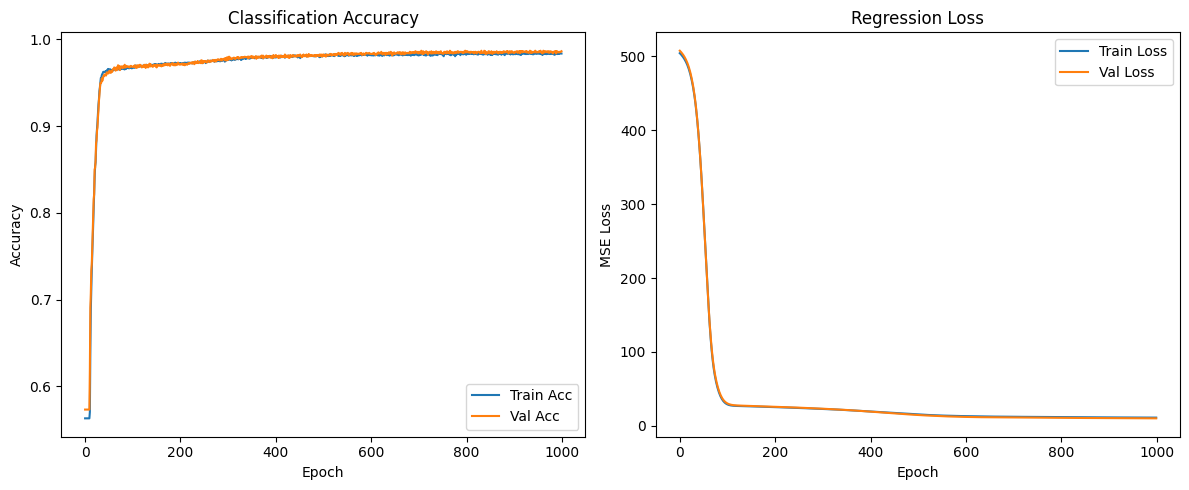

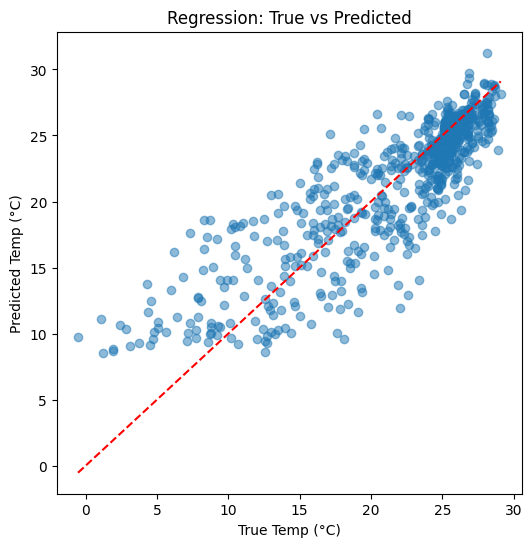

In [ ]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(clf_train_accs, label="Train Acc")
plt.plot(clf_val_accs, label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Classification Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(reg_train_losses, label="Train Loss")
plt.plot(reg_val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Regression Loss")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,6))
plt.scatter(y_true.numpy(), preds.numpy(), alpha=0.5)
mn, mx = y_true.min().item(), y_true.max().item()
plt.plot([mn,mx], [mn,mx], 'r--')
plt.xlabel("True Temp (°C)")
plt.ylabel("Predicted Temp (°C)")
plt.title("Regression: True vs Predicted")
plt.show()

In [ ]:
X_all = torch.tensor(regression_data[:, :2], dtype=torch.float32).to(device)
y_all = torch.tensor(regression_data[:, 2], dtype=torch.float32).cpu().numpy()

reg_model.eval()
with torch.no_grad():
    y_pred_all = reg_model(X_all).cpu().numpy().flatten()

lonlat_scaled = regression_data[:, :2]
lonlat_original = scaler.inverse_transform(lonlat_scaled)
lons, lats = lonlat_original[:,0], lonlat_original[:,1]

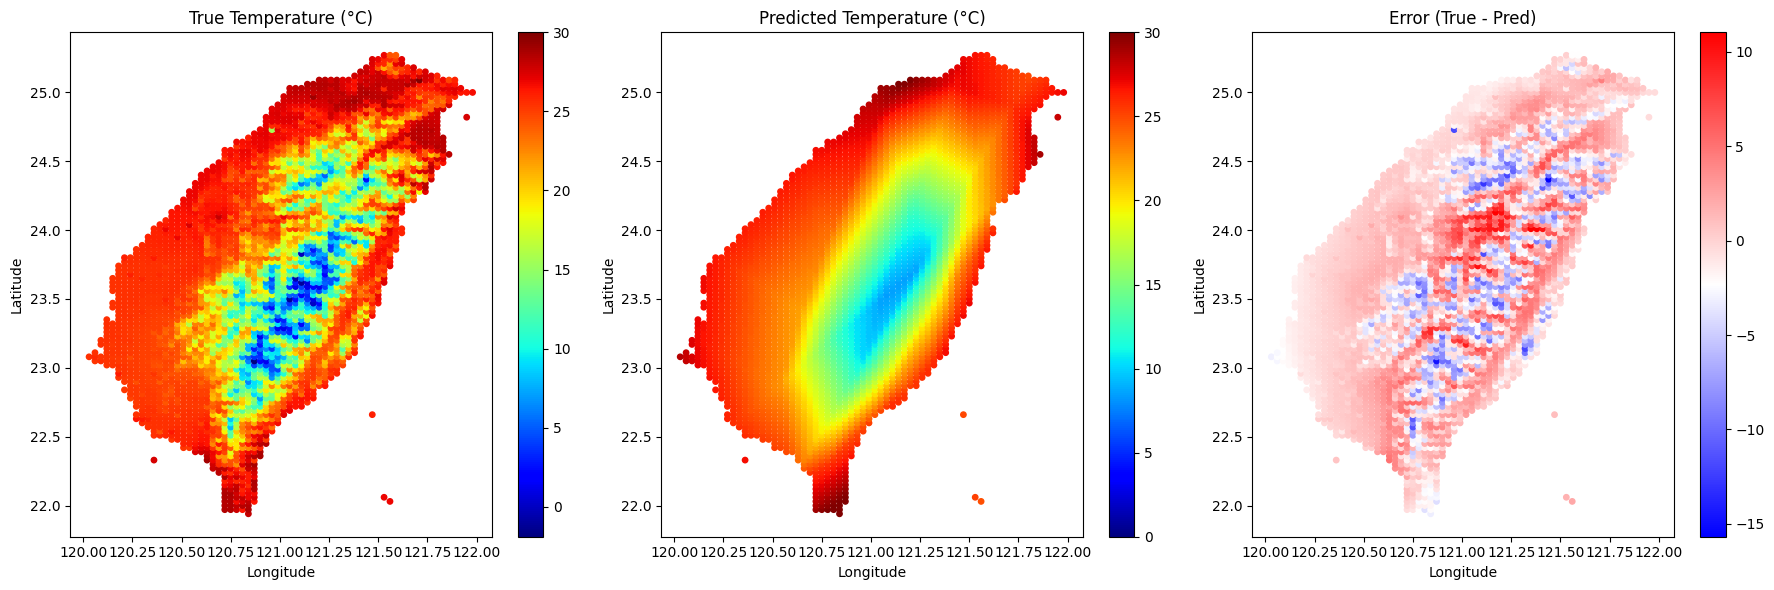

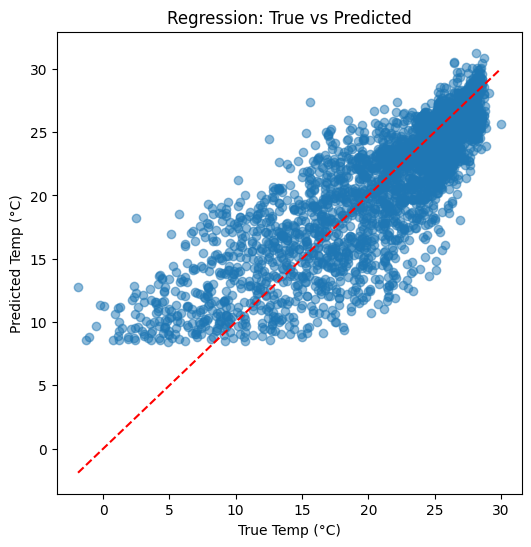

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18,6))

sc1 = axes[0].scatter(lons, lats, c=y_all, cmap="jet", s=15)
axes[0].set_title("True Temperature (°C)")
axes[0].set_xlabel("Longitude")
axes[0].set_ylabel("Latitude")
plt.colorbar(sc1, ax=axes[0])

sc2 = axes[1].scatter(lons, lats, c=y_pred_all, cmap="jet", s=15, vmin=0, vmax=30)
axes[1].set_title("Predicted Temperature (°C)")
axes[1].set_xlabel("Longitude")
axes[1].set_ylabel("Latitude")
plt.colorbar(sc2, ax=axes[1])

sc3 = axes[2].scatter(lons, lats, c=(y_all - y_pred_all), cmap="bwr", s=15)
axes[2].set_title("Error (True - Pred)")
axes[2].set_xlabel("Longitude")
axes[2].set_ylabel("Latitude")
plt.colorbar(sc3, ax=axes[2])

plt.tight_layout()
plt.show()

plt.figure(figsize=(6,6))
plt.scatter(y_all, y_pred_all, alpha=0.5)
mn, mx = y_all.min(), y_all.max()
plt.plot([mn,mx], [mn,mx], 'r--')
plt.xlabel("True Temp (°C)")
plt.ylabel("Predicted Temp (°C)")
plt.title("Regression: True vs Predicted")
plt.show()

Text(0, 0.5, 'Latitude')

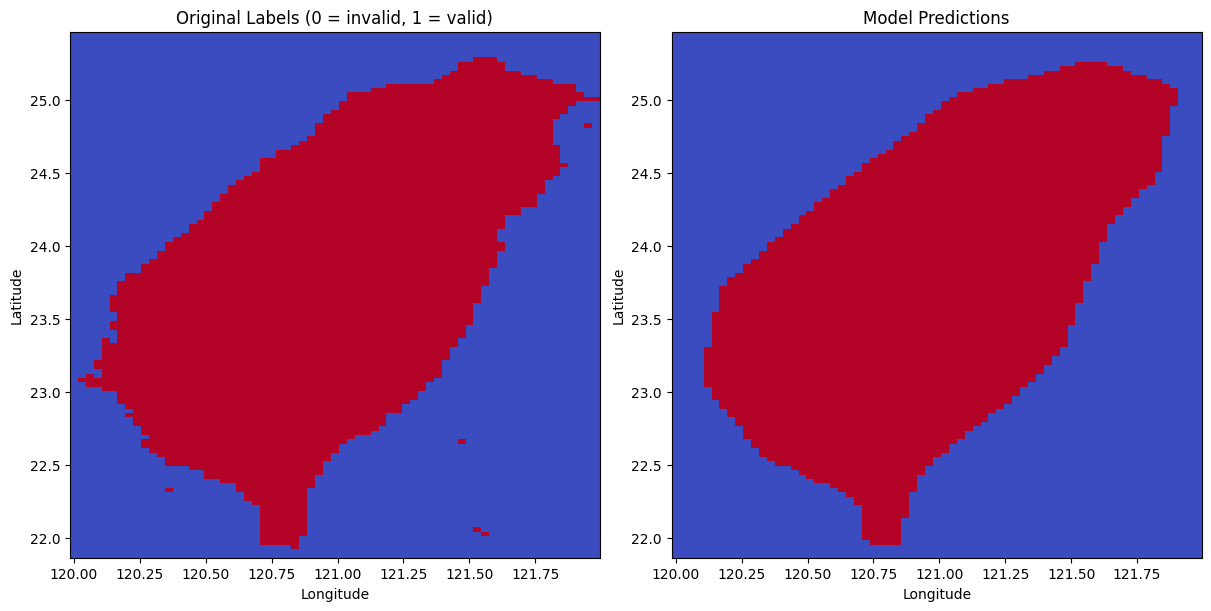

In [ ]:
orig = data
lons = orig[:, 0]
lats = orig[:, 1]
y_true = orig[:, 3].astype(int)

X_scaled = scaler.transform(orig[:, :2])
X_scaled_tensor = torch.tensor(X_scaled, dtype=torch.float32).to(device)
clf_model.eval()
with torch.no_grad():
    logits = clf_model(X_scaled_tensor)
    preds = torch.argmax(logits, dim=1).cpu().numpy()

TP = int(((y_true == 1) & (preds == 1)).sum())
TN = int(((y_true == 0) & (preds == 0)).sum())
FP = int(((y_true == 0) & (preds == 1)).sum())
FN = int(((y_true == 1) & (preds == 0)).sum())
acc = (preds == y_true).mean()

# print(f"Accuracy: {acc:.4f}")
# print(f"TP={TP}, TN={TN}, FP={FP}, FN={FN}")

true_grid = y_true.reshape((n_rows, n_cols))
pred_grid = preds.reshape((n_rows, n_cols))

lon_min = lon0
lon_max = lon0 + (n_cols - 1) * res
lat_min = lat0
lat_max = lat0 + (n_rows - 1) * res
extent = [lon_min - res/2, lon_max + res/2, lat_min - res/2, lat_max + res/2]

fig, axes = plt.subplots(1, 2, figsize=(12,6), constrained_layout=True)

im0 = axes[0].imshow(true_grid, origin='lower', extent=extent, vmin=0, vmax=1, cmap='coolwarm', aspect='auto')
axes[0].set_title('Original Labels (0 = invalid, 1 = valid)')
axes[0].set_xlabel('Longitude')
axes[0].set_ylabel('Latitude')

im1 = axes[1].imshow(pred_grid, origin='lower', extent=extent, vmin=0, vmax=1, cmap='coolwarm', aspect='auto')
axes[1].set_title('Model Predictions')
axes[1].set_xlabel('Longitude')
axes[1].set_ylabel('Latitude')
